# Loading Data Using Herbie
See Herbie documentation: [Herbie](https://herbie.readthedocs.io/en/2024.3.0/user_guide/install.html)


In [24]:
from herbie import Herbie, wgrib2

import matplotlib.pyplot as plt

from cartopy import crs as ccrs, feature as cfeature
import csv
import pandas as pd
import numpy as np
import xarray


In [9]:
H = Herbie(
    "2021-07-19",
    model="hrrr",
    product="sfc",
    fxx=0,
)

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2021-Jul-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [10]:
H.PRODUCTS

{'sfc': '2D surface level fields; 3-km resolution',
 'prs': '3D pressure level fields; 3-km resolution',
 'nat': 'Native level fields; 3-km resolution',
 'subh': 'Subhourly grids; 3-km resolution'}

In [ ]:
# Load each variable for U/V components of wind and surface air pressure at surface
ds_u = H.xarray(':UGRD:10 m')
ds_v = H.xarray(':VGRD:10 m')
ds_p = H.xarray(':PRES:surface')

# Merge datasets
ds = xarray.merge([ds_u, ds_v, ds_p])
ds

<xarray.Dataset>
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2021-07-19
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 10.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2021-07-19
    gribfile_projection  object None
    surface              float64 0.0
Dimensions without coordinates: y, x
Data variables:
    u10                  (y, x) float32 -6.061 -6.061 -6.061 ... 1.189 1.126
    v10                  (y, x) float32 -4.464 -4.526 -4.526 ... 2.661 2.849
    sp                   (y, x) float32 1.014e+05 1.014e+05 ... 1.018e+05
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 prs
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              C:\Users\joebe\data\hrrr\20210719\subset_6eefc91...
    search:                  :UGRD:10 m

In [7]:
# Gather latitude and longitude values for each hurricane track
points = []
currHur = ''
hur = {'latitude': [], 'longitude': [], 'time': []}
with open('filtered_data.csv', 'r') as f_in:
    reader = csv.reader(f_in)
    next(reader)
    for line in reader:
        while len(line[4]) < 4: line[4] = '0' + line[4]
        if currHur != line[0]:
            currHur = line[0]
            currTime = pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M')

            points.append(pd.DataFrame(hur))
            hur = {
                'latitude': [float(line[7])],
                'longitude': [float(line[8])],
                'time': [(pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M') - currTime)/pd.Timedelta('1 hour')]
                }
        else:
            hur['latitude'].append(float(line[7]))
            hur['longitude'].append(float(line[8]))
            hur['time'].append((pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M') - currTime)/pd.Timedelta('1 hour'))

points.pop(0)
points[0]

,latitude,longitude,time
0,21.4,-71.6,0.0
1,21.8,-71.9,2.0
2,22.7,-72.5,6.0
3,24.1,-73.1,12.0
4,25.4,-73.5,18.0
5,26.8,-73.6,24.0
6,28.5,-73.6,30.0
7,30.5,-73.4,36.0
8,32.5,-73.2,42.0
9,34.2,-72.7,48.0


In [8]:
matched = []
for point in points:
    matched.append(ds.herbie.pick_points(point))

matched[0]

AttributeError: 'list' object has no attribute 'herbie'

In [8]:
for i in range(len(matched)):
    matched[i] = matched[i].swap_dims({"point": "point_time"})

(-219013.017232625, 3460978.089089834, -1681795.275537492, 1341151.7247181772)

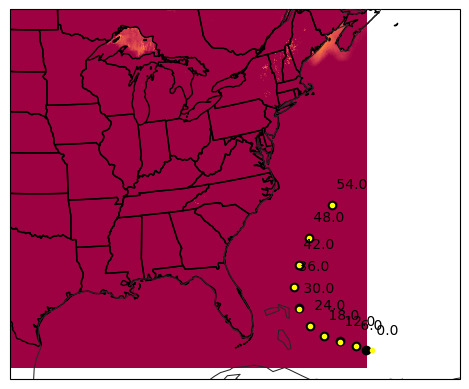

In [9]:
from herbie.toolbox import EasyMap, pc, ccrs

ax = EasyMap(crs=ds.herbie.crs).ax
ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t2m,
    cmap="Spectral_r",
    vmax=290,
    vmin=270,
    transform=pc,
)

for i in matched[50].point_time:
    z = matched[10].sel(point_time=i)
    ax.scatter(z.longitude, z.latitude, color="k", transform=pc)
    ax.scatter(
        z.point_longitude, z.point_latitude, color="yellow", marker=".", transform=pc
    )
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_time.item()}\n",
        transform=pc,
    )
ax.set_extent([-98, -65, 25, 45], crs=pc)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.adjust_extent()

# Using Bounding Box to Create New Data

In [ ]:
from herbie import wgrib2
import os

dir = os.getcwd()
extent = (-97, -72, 25, 35)

H = Herbie(
    "2014-08-31 03:00",
    model="hrrr",
    product="sfc",
    fxx=0,
)



✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-31 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [ ]:
from herbie import Herbie
import xarray as xr
import numpy as np

# Define the extent (latitude and longitude bounds for the East Coast)
east_coast_extent = {
    "latitude": (25, 45),  # Latitude range (south, north)
    "longitude": (-97, -72),  # Longitude range (west, east)
}

# Initialize Herbie for the desired date and model
H = Herbie(
    date="2023-10-01",  # Specify the date
    model="hrrr",  # Specify the model (e.g., HRRR, GFS)
    product="sfc",  # Specify the product (e.g., surface level)
    fxx=0,  # Forecast hour
)

# Download the GRIB2 file (or read it directly into memory)
ds = H.xarray(":TMP:2 m above ground")  # Load a specific variable (e.g., 2m temperature)

# Inspect the dataset's coordinates
print(ds.coords)

# Convert longitude from 0-360 to -180-180 if necessary
longitude = ds.longitude.where(ds.longitude <= 180, ds.longitude - 360)

# Create a mask for the East Coast region
lat_mask = (ds.latitude >= east_coast_extent["latitude"][0]) & (ds.latitude <= east_coast_extent["latitude"][1])
lon_mask = (longitude >= east_coast_extent["longitude"][0]) & (longitude <= east_coast_extent["longitude"][1])
combined_mask = lat_mask & lon_mask

# Apply the mask to the dataset
ds_east_coast = ds.where(combined_mask, drop=True)


ds_east_coast.to_netcdf("east_coast_subset.nc")

# Print or visualize the subset
print(ds_east_coast)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2023-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Coordinates:
    time                 datetime64[ns] 2023-10-01
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2023-10-01
    gribfile_projection  object None
<xarray.Dataset>
Dimensions:              (y: 839, x: 855)
Coordinates:
    time                 datetime64[ns] 2023-10-01
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
    latitude             (y, x) float64 25.02 25.02 25.02 ... 43.31 43.3 43.29
    longitude            (y, x) float64 262.9 262.9 263.0 ... 295.2 295.2 295.2
    valid_time           datetime64[ns] 2023-10-01
    gribfile_projection  object None
Dimensions without coordinates: y, x
Data variables:
  